# Notebook for demonstration of graph algorithms

In this notebook we will explore some of the graph algorithms from the Graph Data Science library.  
The link to the full documentation: https://neo4j.com/docs/graph-data-science/current/algorithms/

In [ ]:
# imports
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience
from matplotlib import pyplot as plt

In [ ]:
DB_ULR = "bolt://localhost:7687" 
DB_USER = "neo4j"
DB_PASS = "1234"
gds = GraphDataScience(DB_ULR, auth=(DB_USER, DB_PASS))

### Similarity algorithm

Similarity algorithm calculates similarity score among all the nodes with the same label.  
The similarity can be calcualted based on the nodes given nodes are pointed to or based on the properties.  
You can read more about the algirthm here: https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/

In our example we will use Similarity algorithm to find claims that are exactly the same, i.e. it is the same claim submitted twice.  
They are created for the same beneficiary, they are submitted by the same provider and they are connected to the same diagnosis nodes, procedures and physicians.  

The first step is to create a graph projection (with the name 'proj-similarity') and specify which nodes from the graph should be used in this projection.  
Note that instead of listing all the relationships, we can just pass '*' to indicate that we are interested in all the relationships among provided node labels.

In [ ]:
# creating the projection of all the beneficiaries and the nodes connected to them
proj_similarity, project_stats = gds.graph.project(
                  'proj_similarity',
                  ['Beneficiary', 'Claim', 'Diagnosis', 'Provider', 'Procedure', 'Physician'],
                  ['*']
              )


The procedure is called 'nodeSimilarity'.  We are using mode 'write' to write the results back to the original database.  
We are creating 'IS_SIMILAR_TO' relationships between the nodes that are similar plus property 'similarity_score' with the actual score.  
Note that in this example the similarity score will be only calculated among 'Claim' nodes, because only these nodes have outgoing relationships.  
We are also specifying similarityCutoff to only store the similarity score in case the value is 1, i.e. all the nodes they are connected to are the same.  

In case of situation where there are multiple nodes with the outgoing relationships you might want to use filteredSimilarity algorithm where it is possible to specify which nodes exactly you want to compare. You can read more about this here https://neo4j.com/docs/graph-data-science/current/algorithms/alpha/filtered-node-similarity/

In [ ]:
# Creating the IS_SIMILAR_TO relationship with similarity_score property
gds.nodeSimilarity.write(proj_similarity,
                writeRelationshipType = 'IS_SIMILAR_TO',
                writeProperty = 'similarity_score',
                similarityCutoff = 1,
                concurrency=16
            )


The best practise is to always drop the created projection after it is not needed anymore.

In [ ]:
# Dropping the graph projection
proj_similarity.drop()

Now you can look for all the Frauds due to submition of the same claim twice.  
Copy paste this query into the browser and check whetehr all the listed providers are fraudulent.  

match (c1)-[:IS_SIMILAR_TO]-(c2)  
match  (b:Beneficiary)-[]-(c1)-[]-(p:Provider)  
return c1, c2, b, p

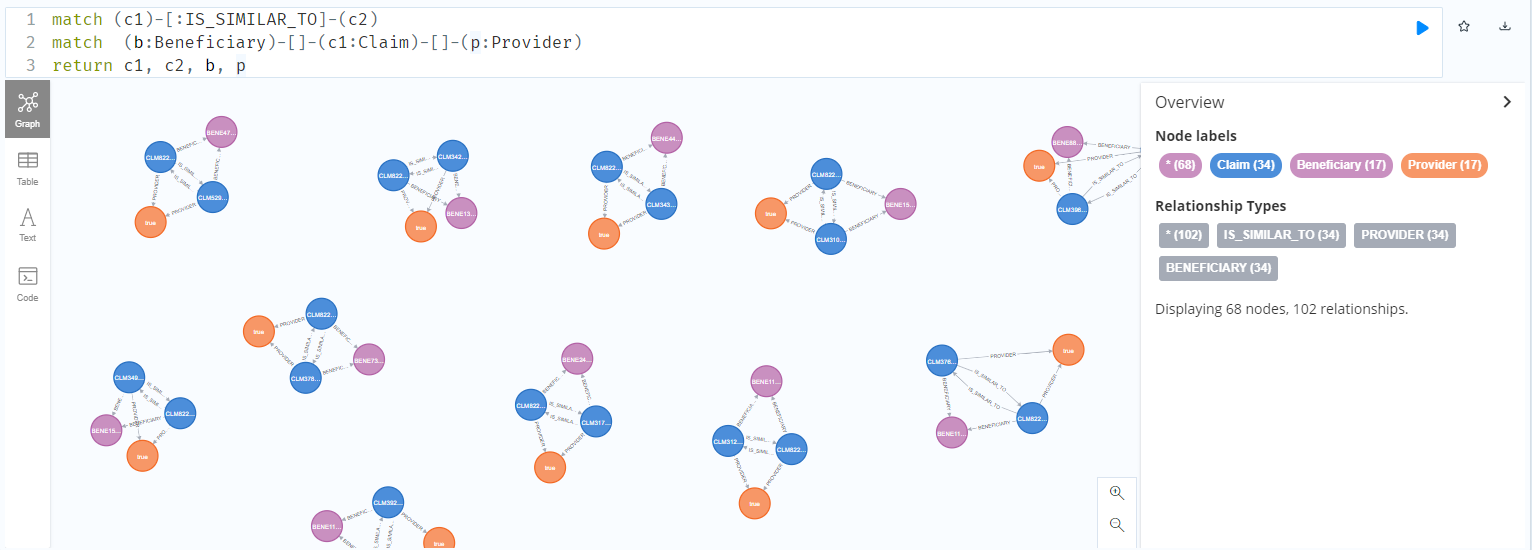

### Betweenness algorithm
Betweeness algorithm looks for nodes that serves as 'bridges' for other nodes.
With this algorithm can be found procedure codes that are most often used by the fraudulent providers as they would be connected to most of the fraudulent claims.

In [ ]:
# Adding label 'Fraud' to claims that are submitted by fraudulent providers
gds.run_cypher('''
              MATCH (c:Claim)-[]-(p:Provider)
              where p.fraud = True
              set c:Fraud
''')

In [ ]:
# Creating projections of fraudulent claims and procedures connected to them
proj_betweenness, project_stats  = gds.graph.project(
                                                'proj_betweenness',
                                                ['Fraud', 'Procedure'], 
                                                { 'HAS_PROCEDURE_CODE_OF': {'orientation': 'UNDIRECTED'} }
                                            )

project_stats

In [ ]:
# Running the betweenness algorithm and creating propery betweenness_score

gds.betweenness.write(proj_betweenness, writeProperty = 'betweenness_score')

In [ ]:
# Dropping the graph projection
proj_betweenness.drop()

#### Exercise 1.1: Query throught the results to get betweeness score of every procedure and whether that procedure is connected also to claims submitted by non-fraudulent providers


#### Exercise 1.2: Create a plot comparing distributions of betweeness scores of procedures connecting to claims submitted by only fraudulent providers and betweeness scores of procedures connecting to claims submitted by non-fraudulent providers as well.

What conclusions can be made from the plot?

### Centrality algorithm

Degree Centrality counts the amount of edges or relationships that go either leave (outdegree) or come into a node (indegree). Important things to keep in mind are direction of relationships and projections. 

Link to neo4j documentation: https://neo4j.com/docs/graph-data-science/current/algorithms/degree-centrality/

Below is an example of how to create a projection, calculate the degree, write the results back to the graph. This is followed by exercises to be solved in teams.

#### Example: Find amount of claims submitted by each provider.

Create a projection considering only the Claims and Providers

In [ ]:
# Create a projection involving claims and providers in order to count the amount of claims each provider handles
claim_provider_degree, project_stats  = gds.graph.project(
    'claim_provider',
    ['Claim', 'Provider'],
    ['SUBMITTED_BY']
)

project_stats

Stream the results with orientations of the realitionships reversed as neo4j counts outdegree.

In [ ]:
# Stream the results to get a quick overview of the results
gds.degree.stream(claim_provider_degree, orientation = 'REVERSE')

Write the results back to the graph database

In [ ]:
# Write the result back to the original graph by creating a new property on the provider and claim nodes
gds.degree.write(claim_provider_degree, orientation = 'REVERSE', writeProperty = 'provider_degree')

#### Exercise 2.1: Query through the result using python to determine whether this would be a good feature to add?
Hint: Find the providers, order by the new property and look at whether the provider is fraudulent.

Drop the projection from the database

In [ ]:
# Drop the graph projections to save memory or fix mistakes
claim_provider_degree.drop()

#### Exercise 2.2: Create a new projection that will find the amount of claims are associated with a physician. Determine whether this would be a good feature to add?

#### Exercise 2.3: Create a new projection that will find the amount of diagnosis that are associated with a claim. Determine whether this would be a good feature to add?

## Community Detection
Community detection algorithms are used to evaluate how groups of nodes are clustered or partitioned, as well as their tendency to strengthen or break apart.

In general, communities may represent similar behaviour/similar interest.

Link to neo4j documentation: https://neo4j.com/docs/graph-data-science/current/algorithms/louvain/

### Investigate if Claims form communities based on the diagnosis codes

In [ ]:
# Graph projection
g_diagnosis, project_stats = gds.graph.project(
    'g_diagnosis', 
    ['Claim', 'Diagnosis'], 
    ['HAS_DIAGNOSIS_CODE_OF', 'HAS_GROUP_CODE_OF'])
project_stats

In [ ]:
# Louvain - The Louvain method is an algorithm to detect communities in large networks. It maximizes a modularity score for each community, 
# where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected 
# the nodes within a community are, compared to how connected they would be in a random network
gds.louvain.stats(g_diagnosis)

In [ ]:
# Let's write back our community_id's to the graph database
gds.louvain.write(g_diagnosis, writeProperty='community_id')

In [ ]:
# Clean up by dropping the graph projection from the graph catalogue
g_diagnosis.drop()

#### Exercise 3.1: Check the communities that have been found. What is the average claim amount? What providers are above average?

#### Exercise 3.2: Check the communities that have been found. What is the number of fraudulent providers per community?

#### Exercise 3.3: Plot the results.

#### What does our communities look like?
Below is an example community where all three providers are labeled fraud. Neo4j Bloom is a useful tool to explore and verify our results.
![Example community where all providers are labeled as fraud](../Data/images/claim_communuty_all_fraud.png)

#### Excercise 3.4: In what other ways can we create communities of claims and what may they represent?
- Instructions: Return to the graph model, in what other way are claims related? In what ways can we make a projection?
- Bonus task: Create your own projection and run a community detection algorithm, evaluate the results visually in Neo4j Bloom and with queries.

In [ ]:
# Projection